# chap 15

In [6]:
# import os
# os.chdir('/mnt/bn/tob-lq/qianweishuo/pytorchTutorial')
# !cd data/ && wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !cd data && unzip hymenoptera_data.zip

['ants', 'bees']


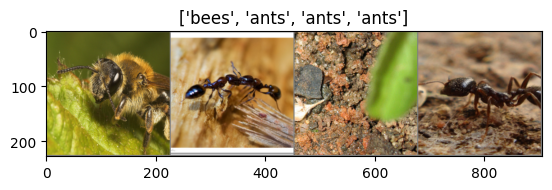

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose(
        [transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean, std)]
    ),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean, std)]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(
    # pretrained=True
    weights=ResNet18_Weights.DEFAULT
)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.8MB/s]


Epoch 0/24
----------
train Loss: 0.6426 Acc: 0.6475
val Loss: 0.4555 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5167 Acc: 0.7500
val Loss: 0.3520 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4341 Acc: 0.8320
val Loss: 0.3025 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3623 Acc: 0.8648
val Loss: 0.2589 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4555 Acc: 0.7746
val Loss: 0.2531 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4081 Acc: 0.8361
val Loss: 0.2369 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3987 Acc: 0.8238
val Loss: 0.2189 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3251 Acc: 0.8893
val Loss: 0.2156 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3537 Acc: 0.8525
val Loss: 0.2151 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3374 Acc: 0.8402
val Loss: 0.2385 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3433 Acc: 0.8607
val Loss: 0.2121 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2856 Acc: 0.9057
val Loss: 0.2111 Acc: 0.9346

Ep

In [10]:
# TODO import ResNet18_Weights

In [12]:
#### ConvNet as fixed feature extractor ####
# Now, the model is ready to be used for inference or further training
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(
    # pretrained=True
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6585 Acc: 0.6516
val Loss: 0.7026 Acc: 0.6471

Epoch 1/24
----------
train Loss: 0.5609 Acc: 0.7500
val Loss: 0.1622 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4508 Acc: 0.8197
val Loss: 0.2675 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3534 Acc: 0.8648
val Loss: 0.2223 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3654 Acc: 0.8074
val Loss: 0.1818 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4303 Acc: 0.8197
val Loss: 0.1859 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3867 Acc: 0.8443
val Loss: 0.1881 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2963 Acc: 0.8770
val Loss: 0.1849 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4168 Acc: 0.7951
val Loss: 0.1883 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3304 Acc: 0.8607
val Loss: 0.1893 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2725 Acc: 0.8689
val Loss: 0.1881 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3810 Acc: 0.8238
val Loss: 0.2094 Acc: 0.9412

Ep

# chap 16

In [ ]:
# 命令行执行 tensorboard --logdir=./runs --port=6006 --bind_all
# 然后从merlin平台访问TensorBoard链接 https://workspace-proxy-candy-lq-tce.byted.org/pbgJHgK2bOzay1G0QUzXfaVuNbHRirTy6/?darkMode=true#pr_curves&run=mnist1&_smoothingWeight=0.221

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
!mkdir -p runs/mnist1  # 注意要早于SummaryWriter()
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist1')
###################################################

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

In [3]:
import os
os.chdir('/mnt/bn/tob-lq/qianweishuo/pytorchTutorial')

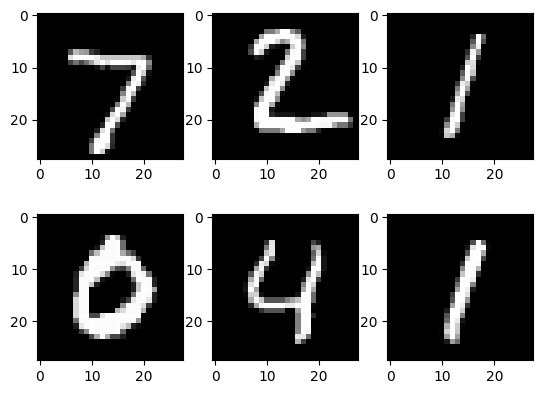

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
# plt.show()

In [15]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
#writer.close()
#sys.exit()
###################################################

In [18]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

############## TENSORBOARD ########################
writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
#writer.close()
#sys.exit()
###################################################

In [19]:
writer.flush()

In [20]:
# Train the model
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            ###################################################

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(labels)

    # 10000, 10, and 10000, 1
    # stack concatenates tensors along a new dimension
    # cat concatenates tensors in the given dimension
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    ###################################################


Epoch [1/1], Step [100/938], Loss: 0.2802
Epoch [1/1], Step [200/938], Loss: 0.2764
Epoch [1/1], Step [300/938], Loss: 0.1743
Epoch [1/1], Step [400/938], Loss: 0.1444
Epoch [1/1], Step [500/938], Loss: 0.1731
Epoch [1/1], Step [600/938], Loss: 0.2203
Epoch [1/1], Step [700/938], Loss: 0.0955
Epoch [1/1], Step [800/938], Loss: 0.1052
Epoch [1/1], Step [900/938], Loss: 0.1458
Accuracy of the network on the 10000 test images: 96.02 %


# chap 17

In [21]:
import torch
import torch.nn as nn

''' 3 DIFFERENT METHODS TO REMEMBER:
 - torch.save(arg, PATH) # can be model, tensor, or dictionary
 - torch.load(PATH)
 - torch.load_state_dict(arg)
'''

''' 2 DIFFERENT WAYS OF SAVING
# 1) lazy way: save whole model
torch.save(model, PATH)

# model class must be defined somewhere
model = torch.load(PATH)
model.eval()

# 2) recommended way: save only the state_dict
torch.save(model.state_dict(), PATH)

# model must be created again with parameters
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_input_features=6)
# train your model...

####################save all ######################################
for param in model.parameters():
    print(param)

# save and load entire model

FILE = "model.pth"
torch.save(model, FILE)

loaded_model = torch.load(FILE)
loaded_model.eval()

for param in loaded_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.4022, -0.3107,  0.2579, -0.0375, -0.1530, -0.1043]],
       requires_grad=True)
Parameter containing:
tensor([0.0888], requires_grad=True)
Parameter containing:
tensor([[-0.4022, -0.3107,  0.2579, -0.0375, -0.1530, -0.1043]],
       requires_grad=True)
Parameter containing:
tensor([0.0888], requires_grad=True)


In [22]:
############save only state dict #########################

# save only state dict
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

print(model.state_dict())
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

print(loaded_model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.4022, -0.3107,  0.2579, -0.0375, -0.1530, -0.1043]])), ('linear.bias', tensor([0.0888]))])
OrderedDict([('linear.weight', tensor([[-0.4022, -0.3107,  0.2579, -0.0375, -0.1530, -0.1043]])), ('linear.bias', tensor([0.0888]))])


In [23]:
###########load checkpoint#####################
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = {
"epoch": 90,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
print(optimizer.state_dict())
FILE = "checkpoint.pth"
torch.save(checkpoint, FILE)

model = Model(n_input_features=6)
optimizer = torch.optim.SGD(model.parameters(), lr=0)

checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

model.eval()
# - or -
# model.train()

print(optimizer.state_dict())

# Remember that you must call model.eval() to set dropout and batch normalization layers 
# to evaluation mode before running inference. Failing to do this will yield 
# inconsistent inference results. If you wish to resuming training, 
# call model.train() to ensure these layers are in training mode.

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}
{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}
